# Processing and gridding gravity data with Fatiando a Terra

**Authors:**
[Santiago Soler](https://github.com/santisoler),
[Andrea Balza Morales](https://github.com/andieie),
[Agustina Pesce](https://github.com/aguspesce),
[Leonardo Uieda](https://github.com/leouieda)

    
In this tutorial, we will walk through the steps of transforming observed absolute gravity measurements into a grid of residual gravity disturbances at a constant height. On our way there, we will showcase some of the core utilities of many of our open-source libraries:

1. Fetch and cache the data using [Pooch](https://github.com/fatiando/pooch)
1. Calculate the gravity disturbance using [Boule](https://github.com/fatiando/boule)
1. Interpolate data and apply map projections to grids using [Verde](https://github.com/fatiando/verde)
1. Perform topographic correction and equivalent-source interpolation using [Harmonica](https://github.com/fatiando/harmonica)

## Study area

The **Bushveld Igneous Complex** is located in South Africa and is the largest known layered igneous intrusion. It has been tilted and eroded forming the outcrops around what appears to be the edge of a great geological basin: the Transvaal Basin. It is approximately 2 billion years old and is divided into four different limbs: the northern, southern, eastern, and western limbs. The Bushveld Complex comprises the Rustenburg Layered suite, the Lebowa Granites and the Rooiberg Felsics, that are overlain by the Karoo sediments. See [Webb et al. (2004)](https://doi.org/10.2113/107.1-2.207) for an overview and previous interpretations of the Bushveld in depth.

<figure>
<img src="images/bushveld_igneous_complex_geology.jpg" alt="Geologic map of the Bushveld Complex">
<figcaption><em>
    Geology and mineral exploration sites of the Bushveld Igneous Complex 
    (<a href="https://en.wikipedia.org/wiki/File:Bushveld_Igneous_Complex.png">public domain</a>).
</em></figcaption>
</figure>

## Import packages

Start by loading everything we need.

In [1]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr

# For projections (wrapped for Proj)
import pyproj

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import pooch
import verde as vd
import boule as bl
import harmonica as hm

## Fetch the gravity and topography data

We can use [Pooch](https://www.fatiando.org/pooch) to download data files from anywhere on the web and store them locally for reuse. 
Let's start by downloading the ground gravity data and topography grid from our [curated sample datasets](https://doi.org/10.5281/zenodo.5167356) stored on [Zenodo](https://zenodo.org).

We'll also download a global geoid model (co-registered with our topography grid) which we'll use to convert the topography from orthometric (referenced to "sea level" or the geoid) to geometric (referenced to the WGS84 ellipsoid) heights. This conversion is required to calculate gravity disturbances instead of anomalies (more on that below).

In [2]:
# The Digital Object Identifier (DOI) of the Zenodo data archive
doi = "10.5281/zenodo.5167357"
path_gravity = pooch.retrieve(
    f"doi:{doi}/southern-africa-gravity.csv.xz", 
    known_hash="md5:1dee324a14e647855366d6eb01a1ef35",
)
path_topography = pooch.retrieve(
    f"doi:{doi}/earth-topography-10arcmin.nc", 
    known_hash="md5:c43b61322e03669c4313ba3d9a58028d",
)
path_geoid = pooch.retrieve(
    f"doi:{doi}/earth-geoid-10arcmin.nc", 
    known_hash="md5:39b97344e704eb68fa381df2eb47da0f",
)
print(path_gravity)
print(path_topography)
print(path_geoid)

/home/leo/.cache/pooch/54dd32a533b3783209a50adf11640117-southern-africa-gravity.csv.xz
/home/leo/.cache/pooch/cfd6d849435e1ca109cf31d2dae3fe32-earth-topography-10arcmin.nc
/home/leo/.cache/pooch/48a36edc9628185b57fa0b9205baf50e-earth-geoid-10arcmin.nc


## Load the data

Now that the data files have been downloaded and cached to our computer, we can use standard Python libraries to load the data.

Use [Pandas](https://pandas.pydata.org/) to read the gravity data from the compressed CSV file.

In [3]:
data = pd.read_csv(path_gravity)
data

,longitude,latitude,height_sea_level_m,gravity_mgal
0,18.34444,-34.12971,32.2,979656.12
1,18.36028,-34.08833,592.5,979508.21
2,18.37418,-34.19583,18.4,979666.46
3,18.40388,-34.23972,25.0,979671.03
4,18.41112,-34.16444,228.7,979616.11
...,...,...,...,...
14354,21.22500,-17.95833,1053.1,978182.09
14355,21.27500,-17.98333,1033.3,978183.09
14356,21.70833,-17.99166,1041.8,978182.69
14357,21.85000,-17.95833,1033.3,978193.18


And use [xarray](https://xarray.pydata.org/) to read the topography and geoid grids from the netCDF file.

In [4]:
topography = xr.load_dataarray(path_topography)
topography

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

In [5]:
geoid = xr.load_dataarray(path_geoid)
geoid

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.6     , -29.6     , -29.6     , ..., -29.6     , -29.6     ,
        -29.6     ],
       ...,
       [ 14.7     ,  14.7     ,  14.7     , ...,  14.7     ,  14.7     ,
         14.7     ],
       [ 15.2     ,  15.2     ,  15.2     , ...,  15.2     ,  15.2     ,
         15.2     ],
       [ 15.400001,  15.400001,  15.400001, ...,  15.400001,  15.400001,
         15.400001]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    [-106.5   86. ]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Crop the data to the Bushveld

The grids are global and the gravity data covers all of Southern Africa. So before we start working we'll need to crop the data to the immediate region around the Bushveld complex. For the topography and geoid grids, we'll use a larger region to avoid edge effects in the topographic correction.

In [6]:
# West, East, South, North (degrees)
region = (25, 32, -27, -23)
# Pad the region for slicing the grids
region_pad = vd.pad_region(region, pad=5)

To slice a `pandas.DataFrame`, we can use [Verde](https://www.fatiando.org/verde/)'s `inside` function to get the index of all points falling inside the given region.

In [7]:
data = data[vd.inside((data.longitude, data.latitude), region)]
data

,longitude,latitude,height_sea_level_m,gravity_mgal
8648,25.01500,-26.26334,1230.2,978681.38
8649,25.01932,-26.38713,1297.0,978669.02
8650,25.02499,-26.39667,1304.8,978669.28
8651,25.04500,-26.07668,1165.2,978681.08
8652,25.07668,-26.35001,1262.5,978665.19
...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85
12975,31.52499,-23.30000,280.7,978798.55
12976,31.54832,-23.19333,245.7,978803.55
12977,31.57333,-23.84833,226.8,978808.44


For the grids, we use the `sel` method of the `xarray.DataArray` objects directly (one of the many perks of using xarray for gridded data).

In [8]:
geoid = geoid.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
topography = topography.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
topography

<xarray.DataArray 'topography' (latitude: 85, longitude: 103)>
array([[ 1013.,  1236.,  1335., ..., -3867., -4446., -4842.],
       [ 1206.,  1270.,  1227., ..., -3790., -4350., -4736.],
       [ 1245.,  1197.,  1104., ..., -3847., -4362., -4703.],
       ...,
       [ 1128.,  1123.,  1113., ...,    -7.,   -32.,   -18.],
       [ 1115.,  1107.,  1098., ...,    17.,   -10.,   -21.],
       [ 1102.,  1094.,  1084., ...,    18.,     9.,   -13.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 20.0 20.17 20.33 20.5 ... 36.67 36.83 37.0
  * latitude   (latitude) float64 -32.0 -31.83 -31.67 ... -18.33 -18.17 -18.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Plot the data

Use [PyGMT](https://www.pygmt.org) to plot the data so we can see what we have. PyGMT is particularly well suited for dealing with spatial data, maps, and projections.

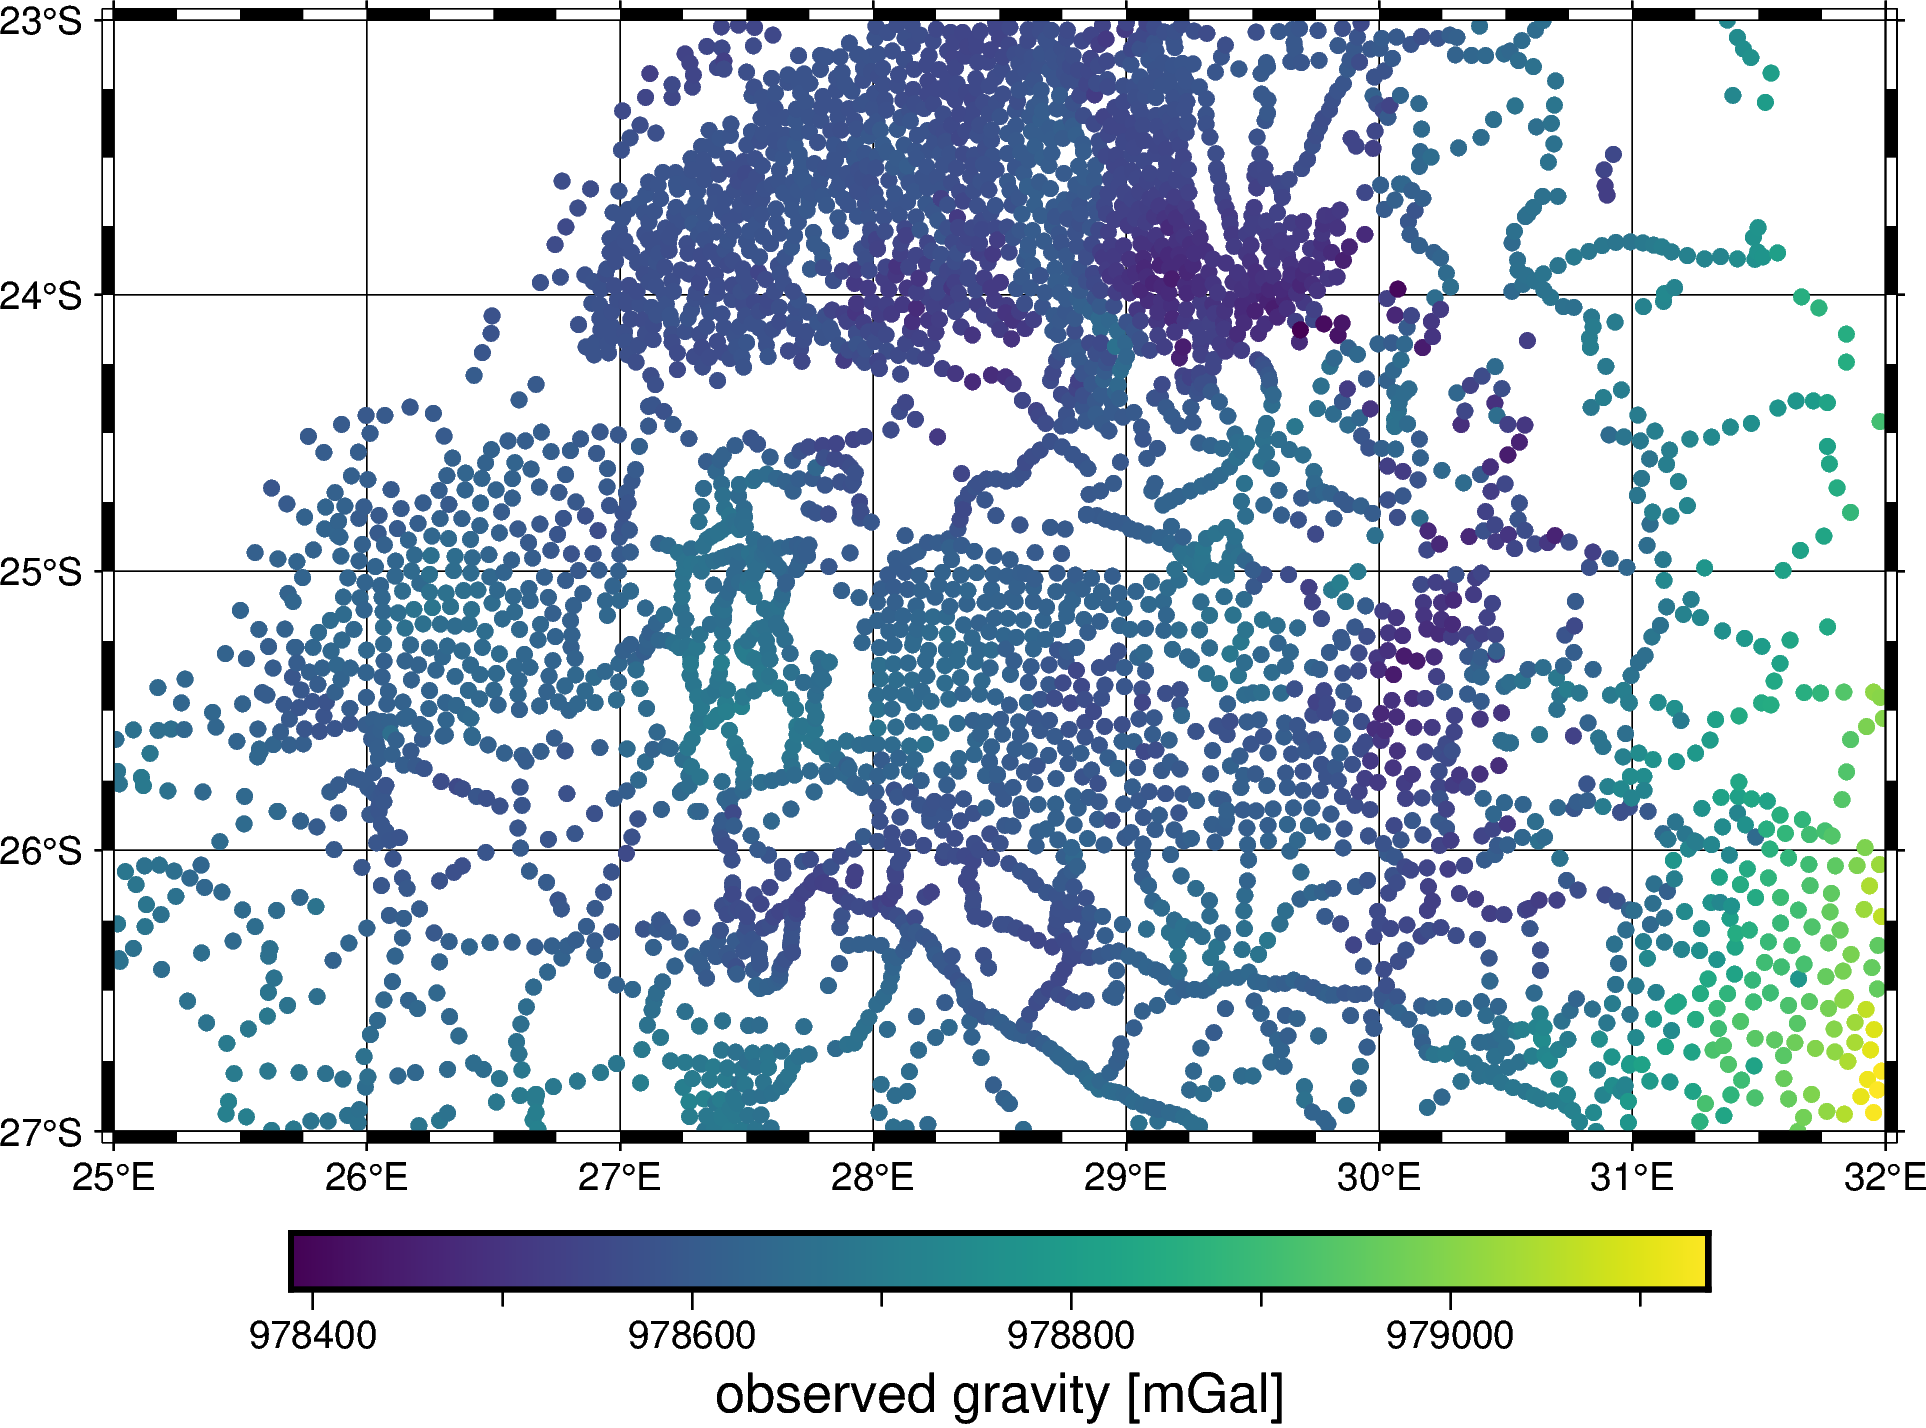

In [9]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="viridis", series=[data.gravity_mgal.min(), data.gravity_mgal.max()])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_mgal,
    cmap=True,
    style="c4p",
    projection="M15c", 
    frame="afg",
)
fig.colorbar(frame='af+l"observed gravity [mGal]"')
fig.show()

Also plot the topography grid with the data points overlaid so we can get a sense for how much topographic variation there is and how much we padded the grids.

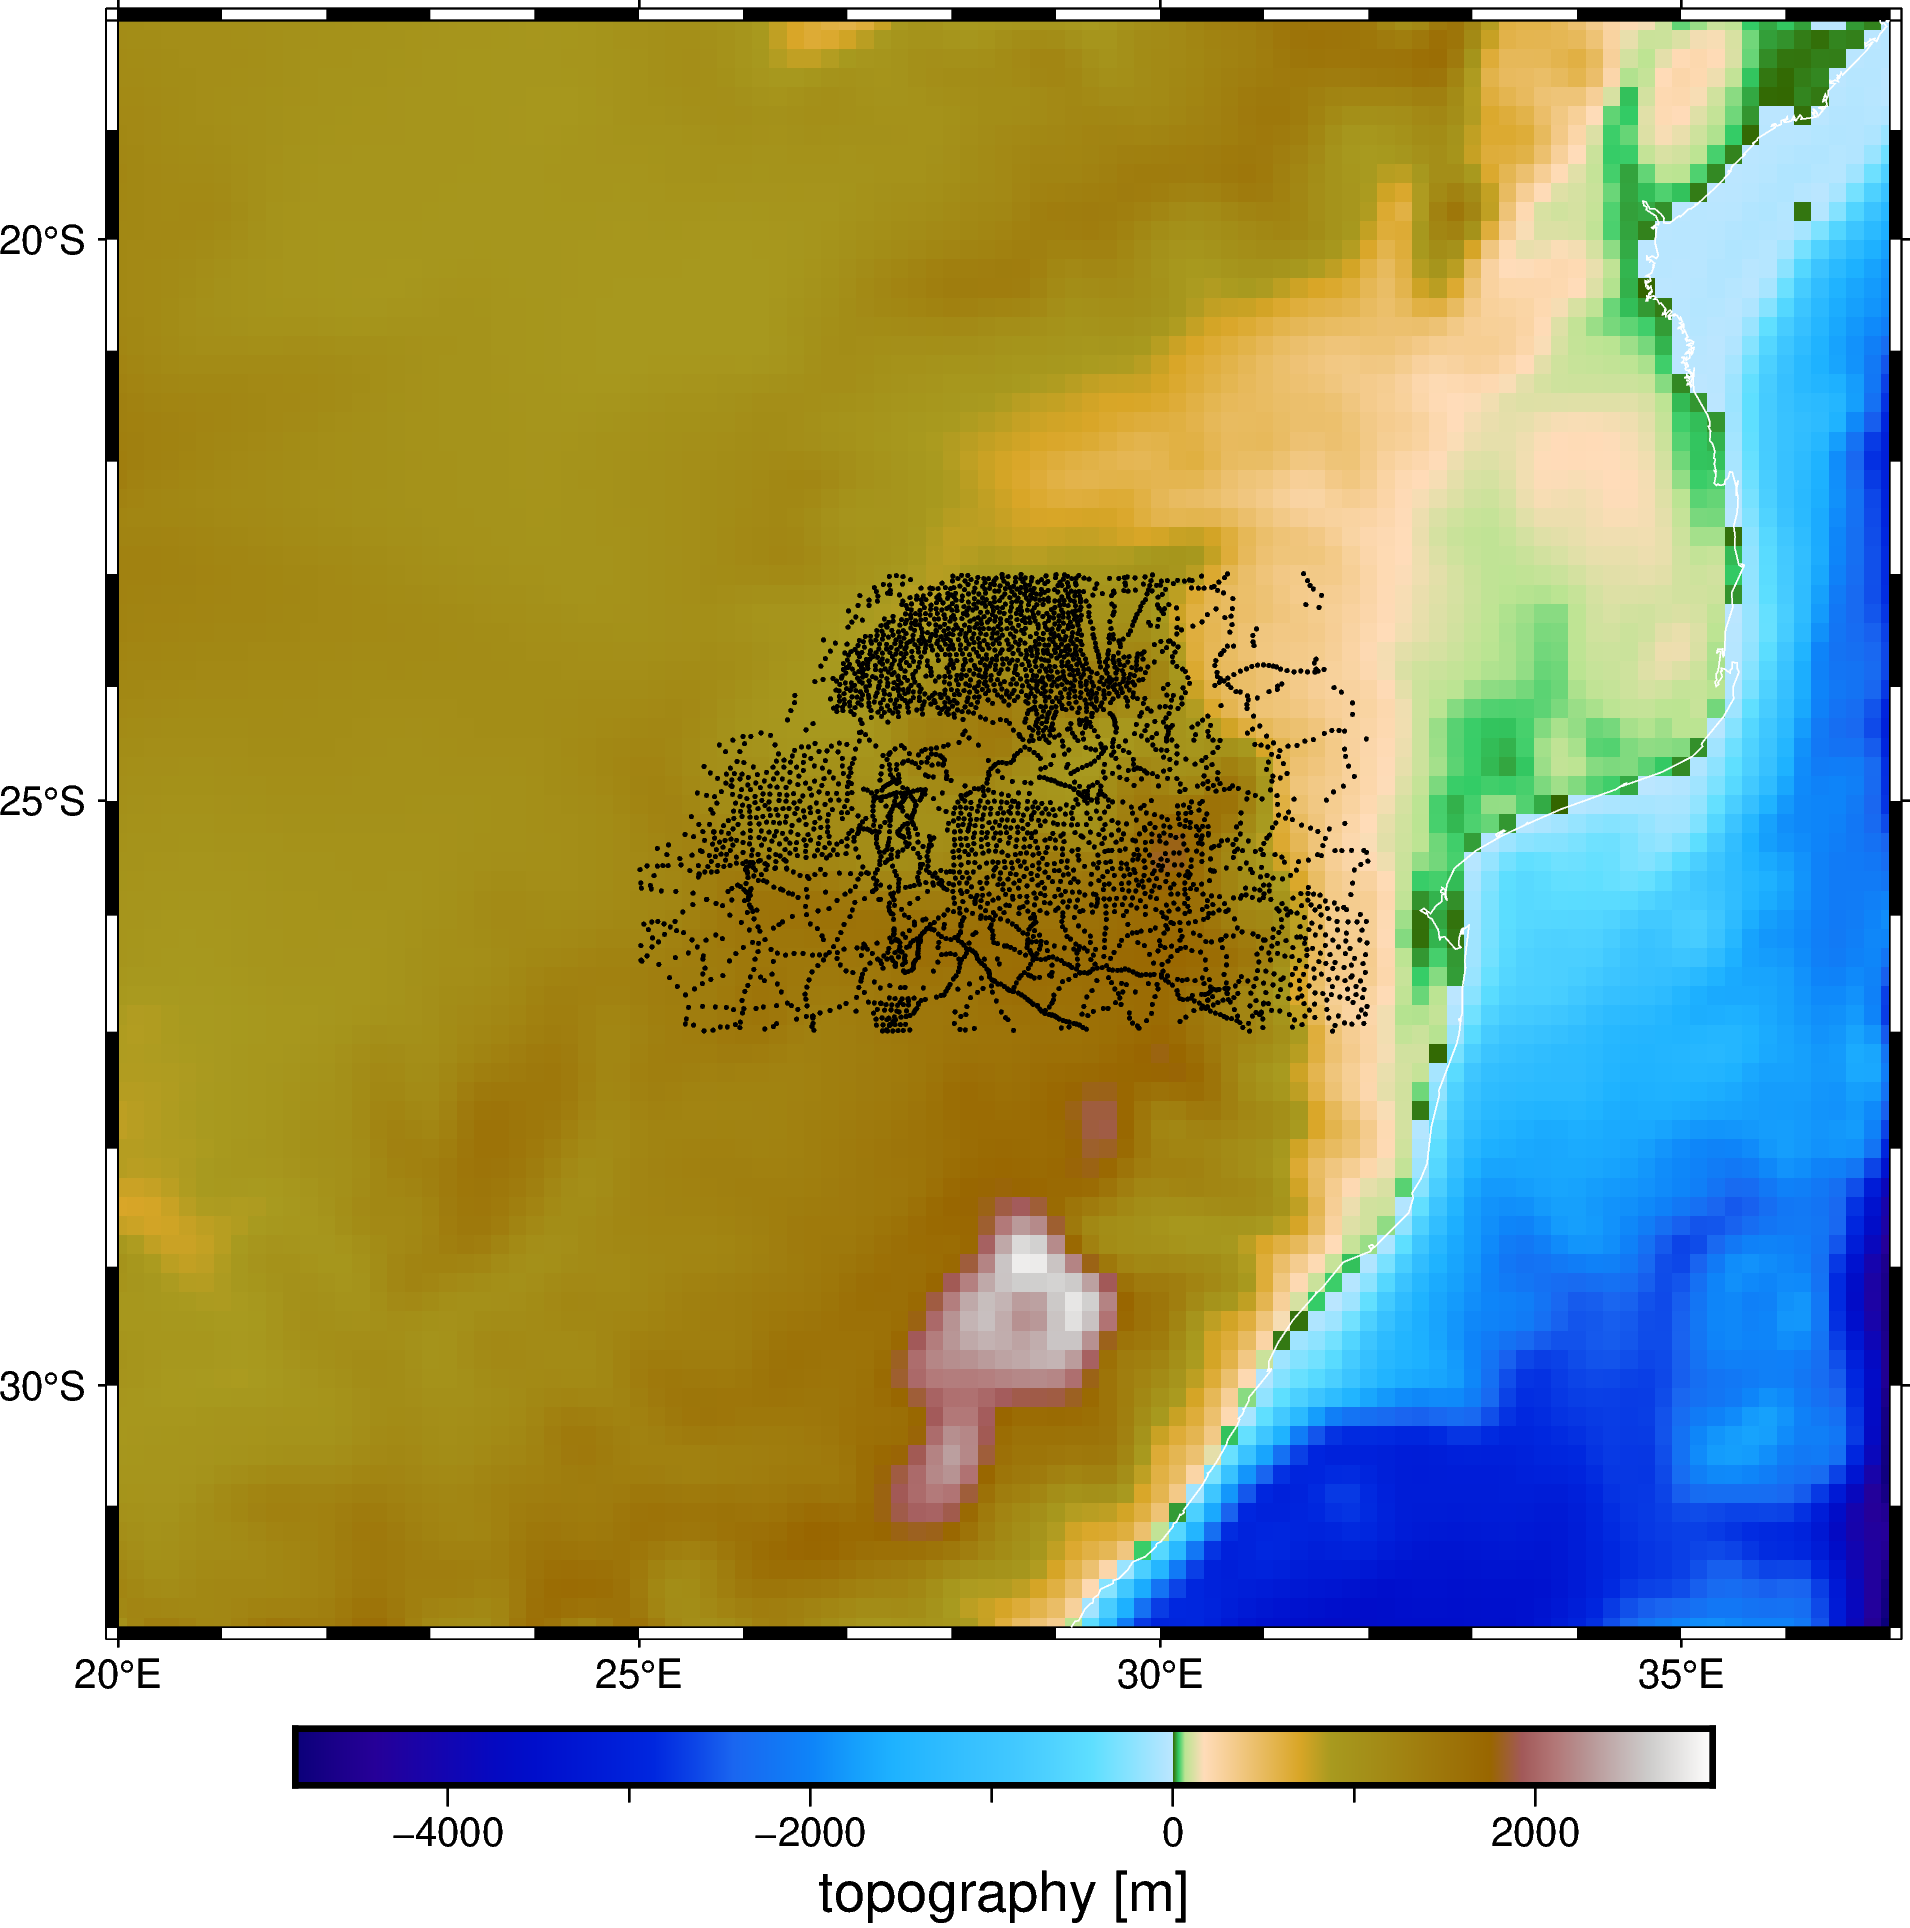

In [10]:
fig = pygmt.Figure()
fig.grdimage(topography, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"topography [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.longitude,
    y=data.latitude,
    style="c0.04c",
    color="black",
)
fig.show()

## Project the grids and data

Since our study area is relatively small, we can use a map projection to transform our geographic data into a Cartesian coordinate system. This simplifies things like interpolation and topographic correction, which are often much faster if performed in Cartesian rather than spherical or geodetic coordinates.

We'll use [pyproj](https://github.com/pyproj4/pyproj) to create a Mercator projection function with latitude of true scale centered on the data.

In [11]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

We can now use the `projection` to transform our gravity data and include the new coordinates in the `pandas.DataFrame`.

In [12]:
easting, northing = projection(data.longitude.values, data.latitude.values)
data = data.assign(easting_m=easting, northing_m=northing)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06


Projecting the grids is more complicated since it involves some interpolation to maintain evenly spaced grid nodes. Verde provides the `project_grid` function that performs all of these calculations automatically for us. We'll use nearest-neighbor interpolation here since it's faster and our project doesn't warp the data too much.

In [13]:
topography_proj = vd.project_grid(topography, projection, method="nearest")
geoid_proj = vd.project_grid(geoid, projection, method="nearest")
topography_proj

<xarray.DataArray 'topography' (northing: 85, easting: 103)>
array([[ 1.1245e+03,  1.1245e+03,  1.3350e+03, ..., -3.5210e+03,
        -4.4460e+03, -4.8420e+03],
       [ 1.2380e+03,  1.2380e+03,  1.2270e+03, ..., -3.4570e+03,
        -4.3500e+03, -4.7360e+03],
       [ 1.2210e+03,  1.2210e+03,  1.1040e+03, ..., -3.5170e+03,
        -4.3620e+03, -4.7030e+03],
       ...,
       [ 1.1255e+03,  1.1255e+03,  1.1130e+03, ...,  3.5000e+00,
        -3.2000e+01, -1.8000e+01],
       [ 1.1045e+03,  1.1045e+03,  1.0910e+03, ...,  1.1750e+01,
        -5.0000e-01, -1.7000e+01],
       [ 1.1045e+03,  1.1045e+03,  1.0910e+03, ...,  1.1750e+01,
        -5.0000e-01, -1.7000e+01]], dtype=float32)
Coordinates:
  * easting   (easting) float64 2.02e+06 2.036e+06 ... 3.72e+06 3.736e+06
  * northing  (northing) float64 -3.393e+06 -3.375e+06 ... -1.855e+06 -1.836e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

## Reference heights to the ellipsoid

Before we can calculate gravity disturbances, we need both the observation height and the topography to be referenced to the ellipsoid instead of "sea level" or the geoid. We can do that by adding the geoid height to the current heights.

In [14]:
topography_geometric = topography_proj + geoid_proj
topography_geometric

<xarray.DataArray (northing: 85, easting: 103)>
array([[ 1.1603000e+03,  1.1603000e+03,  1.3718000e+03, ...,
        -3.4988999e+03, -4.4250000e+03, -4.8216001e+03],
       [ 1.2743000e+03,  1.2743000e+03,  1.2638000e+03, ...,
        -3.4351499e+03, -4.3292998e+03, -4.7158999e+03],
       [ 1.2573500e+03,  1.2573500e+03,  1.1406000e+03, ...,
        -3.4955000e+03, -4.3417002e+03, -4.6833999e+03],
       ...,
       [ 1.1438500e+03,  1.1438500e+03,  1.1305000e+03, ...,
        -5.0000000e+00, -4.0200001e+01, -2.6000000e+01],
       [ 1.1221500e+03,  1.1221500e+03,  1.1079000e+03, ...,
         2.5499992e+00, -9.3999996e+00, -2.5600000e+01],
       [ 1.1221500e+03,  1.1221500e+03,  1.1079000e+03, ...,
         2.5499992e+00, -9.3999996e+00, -2.5600000e+01]], dtype=float32)
Coordinates:
  * easting   (easting) float64 2.02e+06 2.036e+06 ... 3.72e+06 3.736e+06
  * northing  (northing) float64 -3.393e+06 -3.375e+06 ... -1.855e+06 -1.836e+06

For the observation heights, we have to interpolate the geoid height values at the same points as the observations. We can do this with the cubic interpolation in Verde.

In [15]:
# Unravel the grid so that we can pass it to the interpolator
geoid_table = vd.grid_to_table(geoid_proj)
interpolator = vd.ScipyGridder(method="cubic")
interpolator.fit((geoid_table.easting, geoid_table.northing), geoid_table.geoid)
# Predict the geoid height at same locations as the observation points
data = data.assign(geoid_m=interpolator.predict((data.easting_m, data.northing_m)))
data = data.assign(height_geometric_m=data.height_sea_level_m + data.geoid_m)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,geoid_m,height_geometric_m
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,27.302536,1257.502536
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,27.659737,1324.659737
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,27.689820,1332.489820
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,26.915163,1192.115163
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,27.540560,1290.040560
...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,12.527840,313.027840
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,11.987479,292.687479
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,11.897978,257.597978
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,12.483330,239.283330


## Gravity disturbance

The gravity disturbance is defined as:

$$
\delta g (\lambda, \phi, h) = g (\lambda, \phi, h) - \gamma (\lambda, \phi, h)
$$

in which $(\lambda, \phi, h)$ are the longitude, latitude, and geometric height, $g$ is the observed gravity acceleration, and $\gamma$ is the calculated **normal gravity** of a reference ellipsoid. 
Notice that all 3 quantities are located at the same point (the observation point).

> **A note on disturbances vs anomalies:** We want to calculate the disturbance instead of the traditional "gravity anomaly" $\Delta g(\lambda, \phi) = g(\lambda, \phi, h=N) - \gamma(\lambda, \phi, h=0)$ because the anomaly is not exclusively related to the subsurface density anomalies, while the gravity disturbance is. In fact, it does not even make sense talking about the "height of the gravity anomaly" since by definition it is only variable in longitude and latitude. Most geophysicists will agree that, in practice, the "height" of observations matter for modeling and interpretation. In most cases, even if we calculate gravity anomalies, we end up pretending that they are gravity disturbances when interpreting the data. So why not calculate disturbances directly?

We can use [Boule](https://www.fatiando.org/boule) to compute the **normal gravity** of the WGS84 reference ellipsoid on any point outside of the ellipsoid using a closed-form equation. This eliminates the need for a free-air correction, which is a rough approximation at best. With that, we can compute the gravity disturbance and store it in our `pandas.DataFrame`.

In [16]:
data = data.assign(
    normal_gravity_mgal=bl.WGS84.normal_gravity(data.latitude, data.height_geometric_m)
)
data = data.assign(gravity_disturbance_mgal=data.gravity_mgal - data.normal_gravity_mgal)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,geoid_m,height_geometric_m,normal_gravity_mgal,gravity_disturbance_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,27.302536,1257.502536,978656.289769,25.090231
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,27.659737,1324.659737,978644.455439,24.564561
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,27.689820,1332.489820,978642.725739,26.554261
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,26.915163,1192.115163,978663.122713,17.957287
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,27.540560,1290.040560,978652.468478,12.721522
...,...,...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,12.527840,313.027840,978781.535934,-4.685934
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,11.987479,292.687479,978750.536972,48.013028
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,11.897978,257.597978,978754.386590,49.163410
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,12.483330,239.283330,978803.297086,5.142914


Now plot the gravity disturbance that we just calculated on a map.

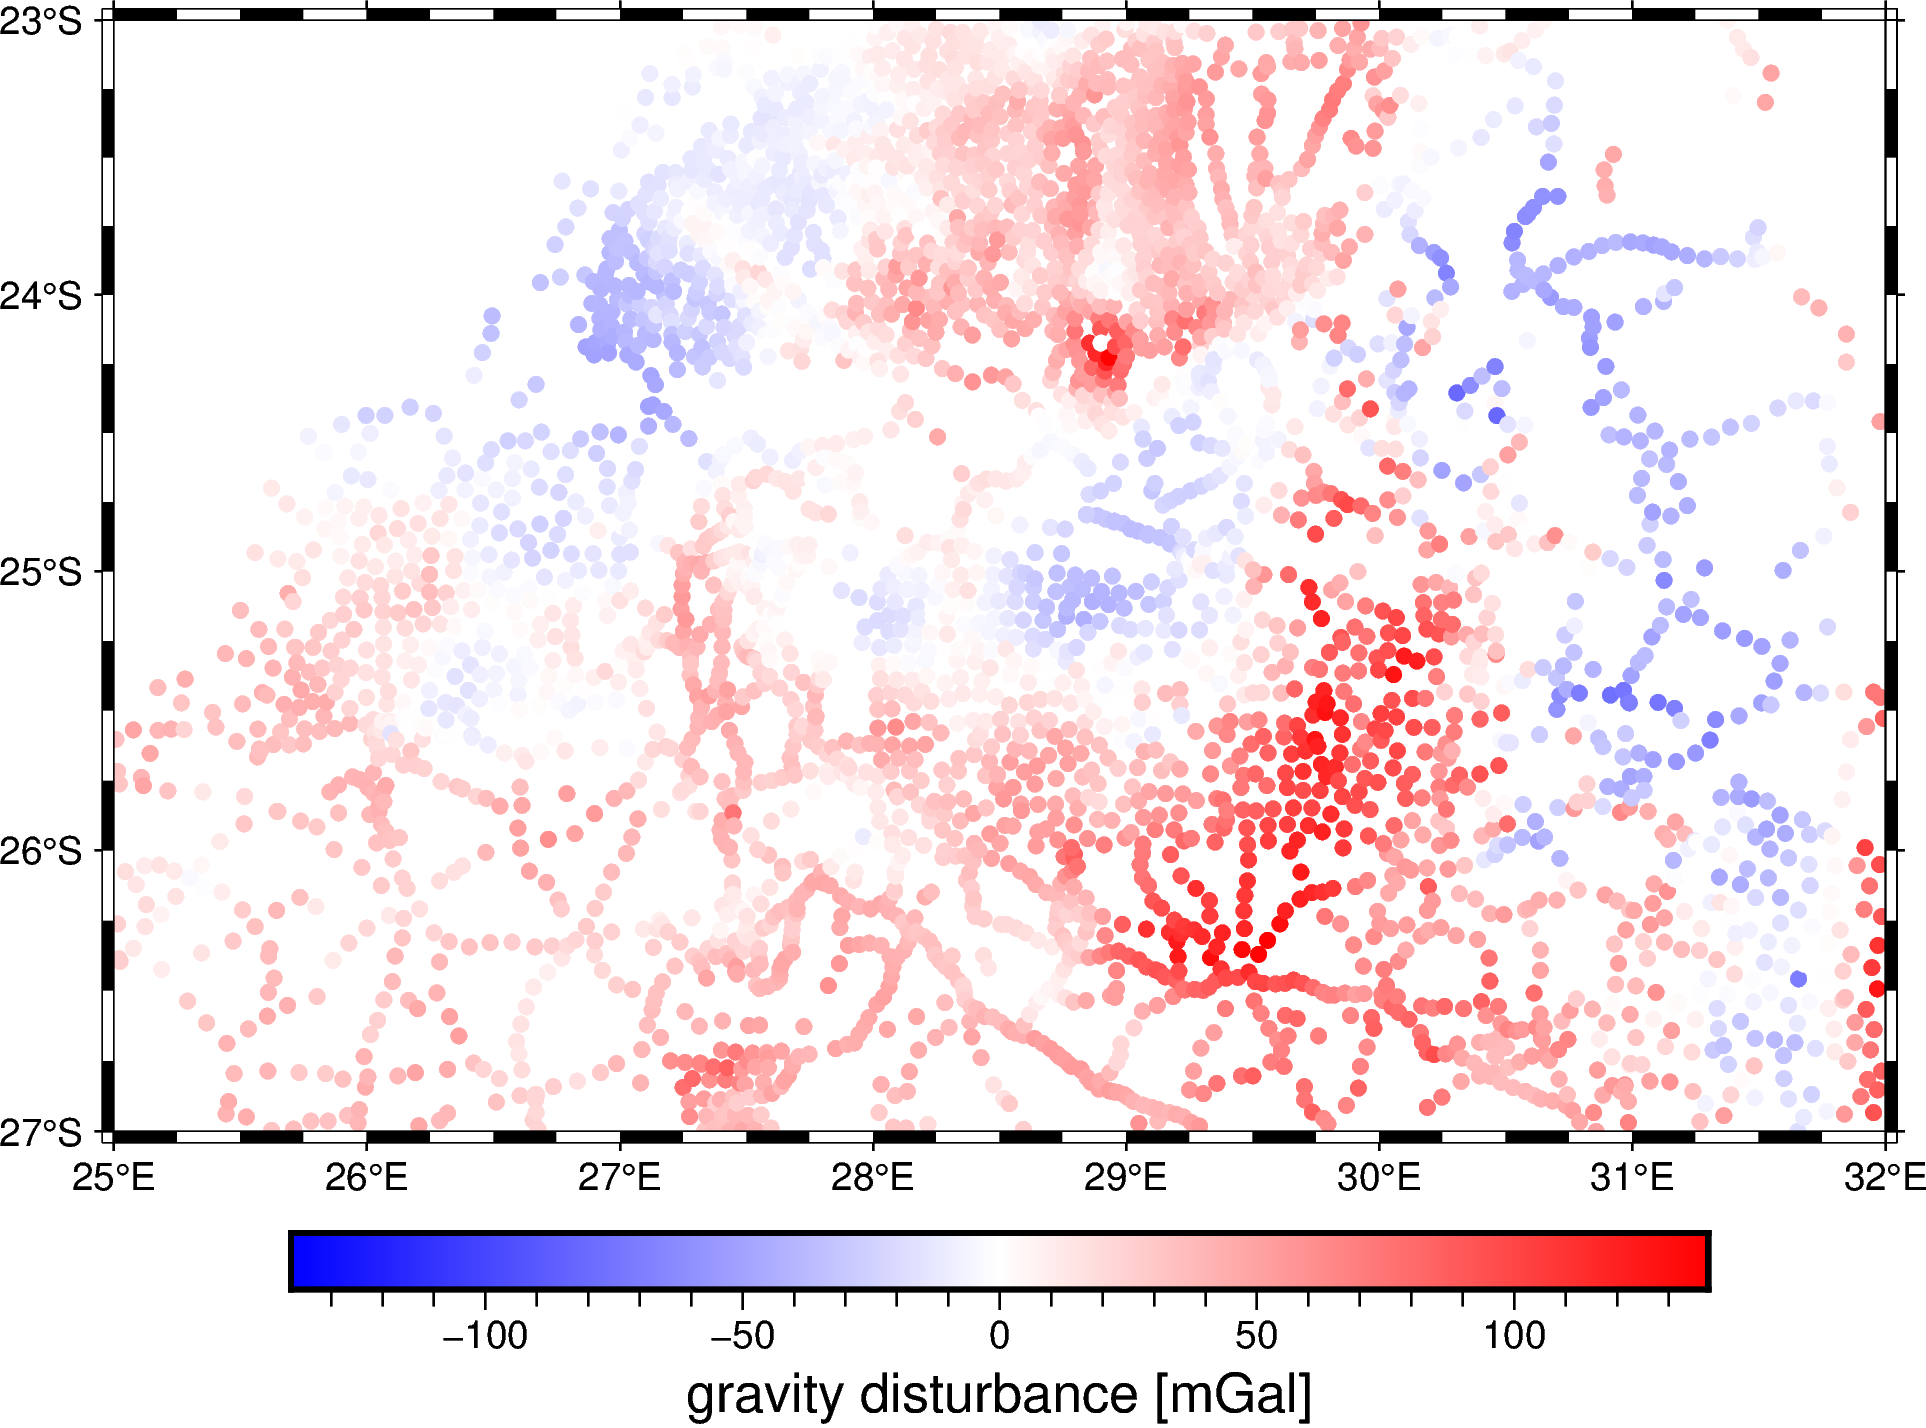

In [17]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_disturbance_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_disturbance_mgal,
    cmap=True,
    style="c4p",
    projection="M15c", 
    frame="af",
)
fig.colorbar(frame='af+l"gravity disturbance [mGal]"')
fig.show()

## Topographic correction

Now that we have removed normal gravity and calculated a gravity disturbance, the next step is to remove the effect of the topographic and oceanic masses above and below the ellipsoid. We need to do this in order to isolate the effect of the Bushveld rocks.

We will use [Harmonica](https://www.fatiando.org/harmonica) to calculate and remove the gravitational effect of the topography by modeling the masses as a layer of right-rectangular prisms.

The `prism_layer` function creates a prism model based on a surface undulating around a reference level. In our case, the reference is the ellipsoid (0 height) and the surface is our topography (as geometric heights). The difficult part is assigning the correct density (or density contrast) to each part of our model:

* $\rho = 2670\ kg/m^3$ for continental parts above the ellipsoid
* $\rho = -2670\ kg/m^3$ for continental parts below the ellipsoid 
* $\rho = 1040 - 2670\ kg/m^3$ in the oceans (1040 being an approximate density of ocean water)

Here we'll define "continental" as places with positive orthometric height since 0 orthometric height roughly matches the coastlines.

<figure>
<img src="images/topographic-correction.svg" alt="Sketch of the surfaces and masses involved in topographic correction of gravity disturbances.">
<figcaption><em>
    Sketch of the surfaces and masses involved in topographic correction of gravity disturbances. 
    (CC-BY).
</em></figcaption>
</figure>

> **Note:** There is an extra effect of under- and over-correcting for ocean water in the oceans. This happens because we are assuming that the surface of the water is at 0 geometric height (the surface of the ellipsoid) when in fact it roughly follows the geoid. So in oceanic places where the geoid is below the ellipsoid, we correct for water where there was none and vice-versa. Luckily, this effect is negligible here since our study area is relatively far away from the ocean. We can safely ignore this correction but it should be performed when close to the coast or directly above the oceans.

In [18]:
# Start by placing the continental density above and below the ellipsoid
topography_density = np.where(topography_geometric > 0, 2670, -2670)
# Now correct the value in the oceans (topography < 0)
topography_density = np.where(topography_proj < 0, 1040 - 2670, topography_density)
# Create the prism model of the topographic masses
topography_model = hm.prism_layer(
    coordinates=(topography_geometric.easting, topography_geometric.northing),
    surface=topography_geometric,
    reference=0,
    properties={"density": topography_density}
)
topography_model

<xarray.Dataset>
Dimensions:   (northing: 85, easting: 103)
Coordinates:
  * easting   (easting) float64 2.02e+06 2.036e+06 ... 3.72e+06 3.736e+06
  * northing  (northing) float64 -3.393e+06 -3.375e+06 ... -1.855e+06 -1.836e+06
    top       (northing, easting) float32 1.16e+03 1.16e+03 ... 0.0 0.0
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 -9.4 -25.6
Data variables:
    density   (northing, easting) int64 2670 2670 2670 2670 ... 2670 -1630 -1630
Attributes:
    coords_units:      meters
    properties_units:  SI

To help us visually what this correction is doing, let's take a look at the density that we assigned across our topographic model.

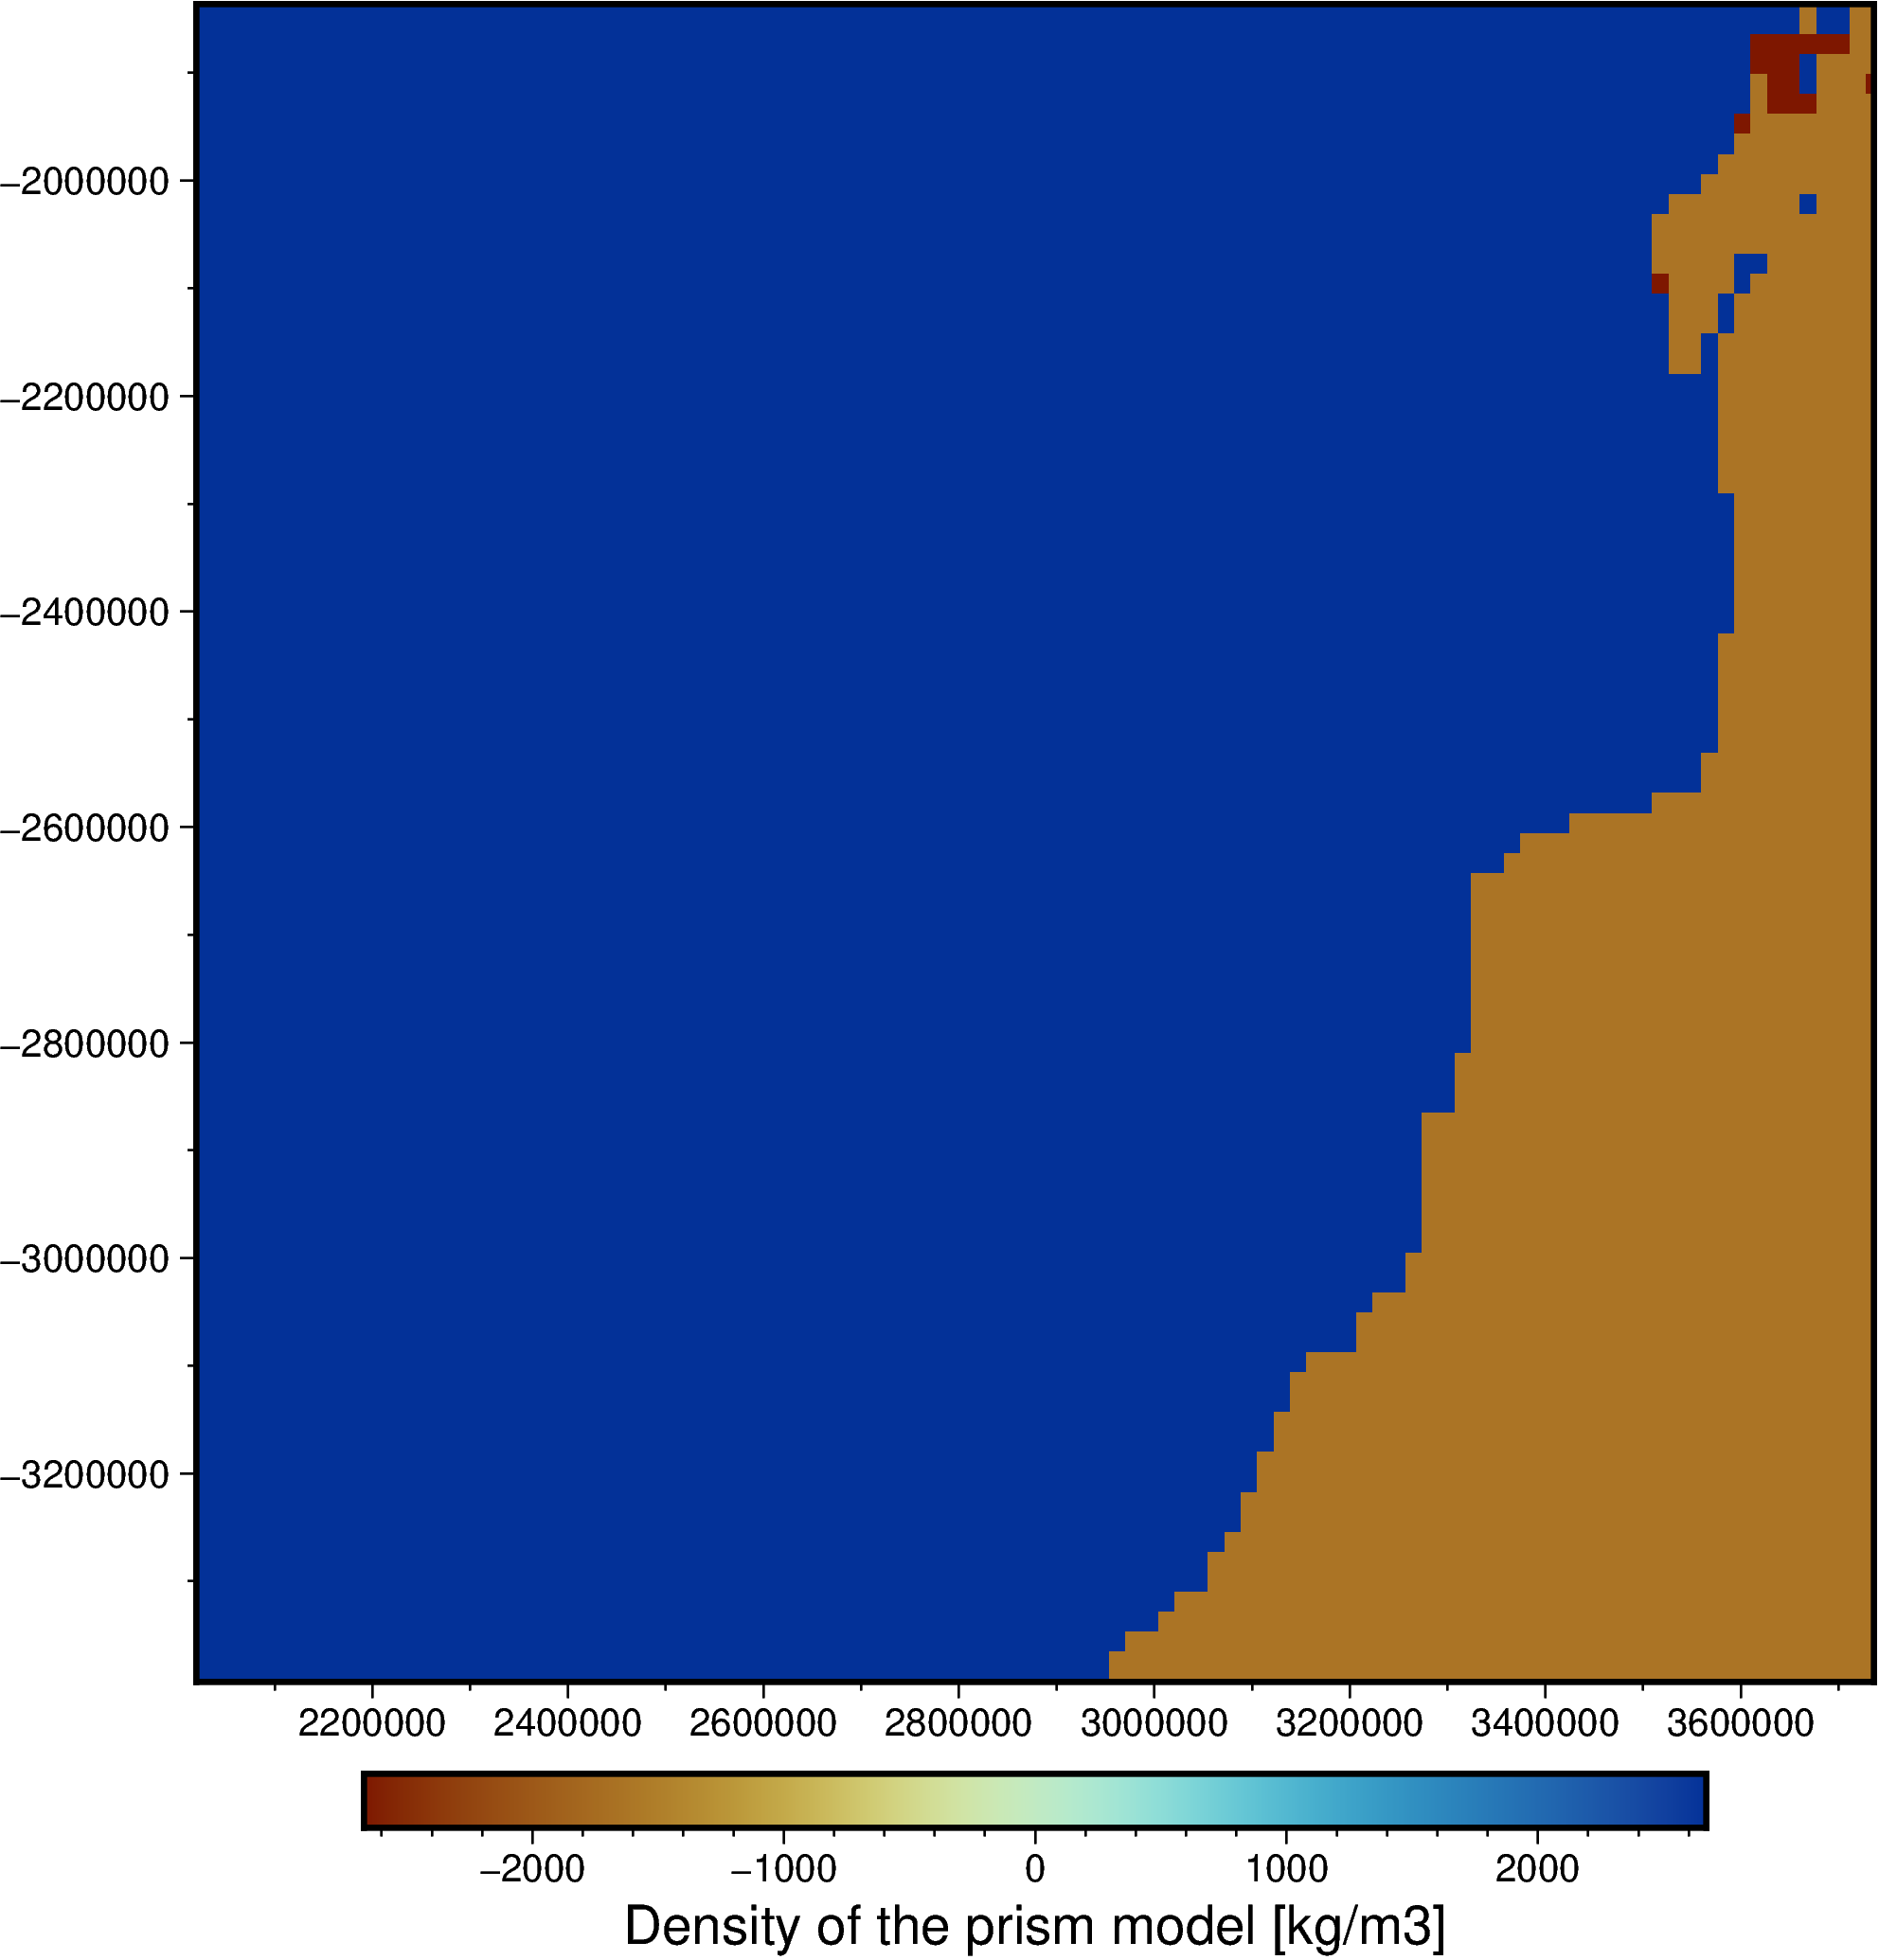

In [19]:
fig = pygmt.Figure()
fig.grdimage(topography_model.density, projection="X15c", cmap="roma+h", frame=True)
fig.colorbar(frame='af+l"Density of the prism model [kg/m3]"')
fig.show()

As prescribed by the model, the density is 2670 kg/m³ in the continents and 1040 - 2670 kg/m³ in the oceans. The exceptions are parts of the continents that are below 0 geometric height, which have a density of -2670 kg/m³.

Now we can forward model the gravitational effect of the topographic/bathymetric masses at the data points and remove it from our gravity disturbance to calculate a **topography-free (Bouguer) disturbance**.

In [20]:
coordinates = (data.easting_m, data.northing_m, data.height_geometric_m)
data = data.assign(
    terrain_effect_mgal=topography_model.prism_layer.gravity(coordinates, field="g_z"),
)
data = data.assign(
    gravity_bouguer_mgal=data.gravity_disturbance_mgal - data.terrain_effect_mgal
)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,geoid_m,height_geometric_m,normal_gravity_mgal,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,27.302536,1257.502536,978656.289769,25.090231,139.812249,-114.722018
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,27.659737,1324.659737,978644.455439,24.564561,145.905545,-121.340984
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,27.689820,1332.489820,978642.725739,26.554261,145.905317,-119.351056
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,26.915163,1192.115163,978663.122713,17.957287,129.444479,-111.487193
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,27.540560,1290.040560,978652.468478,12.721522,142.540230,-129.818707
...,...,...,...,...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,12.527840,313.027840,978781.535934,-4.685934,34.376896,-39.062830
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,11.987479,292.687479,978750.536972,48.013028,29.023204,18.989825
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,11.897978,257.597978,978754.386590,49.163410,20.736237,28.427173
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,12.483330,239.283330,978803.297086,5.142914,18.758079,-13.615165


Plot the Bouguer disturbance on a map so we can see what we have.

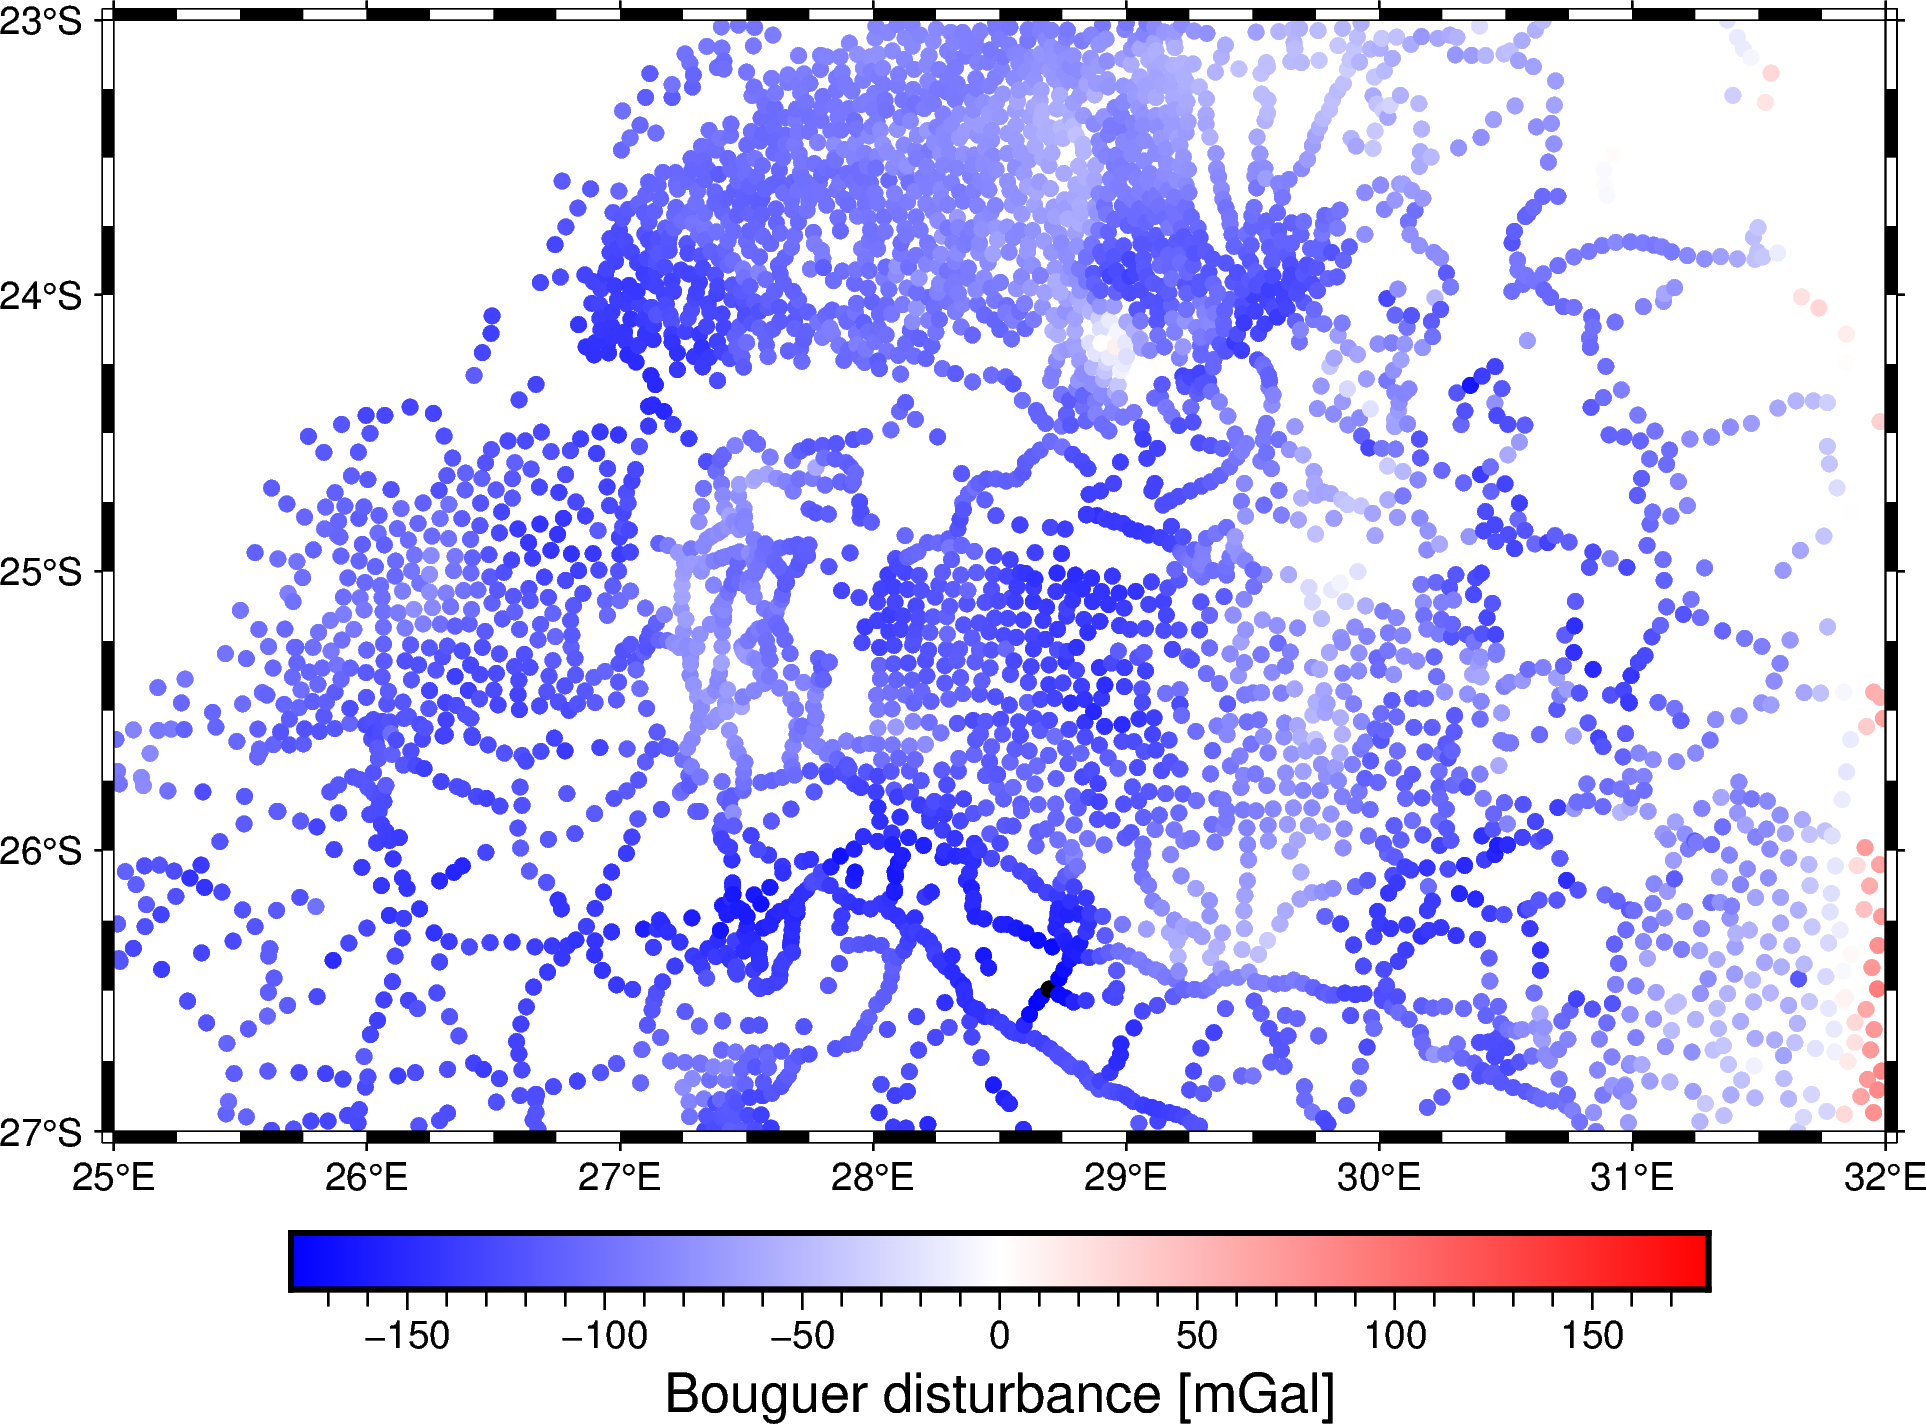

In [21]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_bouguer_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_bouguer_mgal,
    cmap=True,
    style="c4p",
    projection="M15c", 
    frame=True,
)
fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
fig.show()

As expected, the values are mostly negative and are dominated by the Moho signal.

## Regional-residual separation

If we want to see the signal from the shallower intrusions of the Bushveld, we'll need to remove the effect of the deeper and larger sources (often called the **regional**). 

Traditionally, this is done by fitting a low-degree 2D polynomial to the data and using it as the regional field. We could do this with `verde.Trend` but we'll use a different (and better) approach. The reason for not using a polynomial is that it doesn't take into account the variable height of the observations or the physical nature of the data (a potential field). Here, we will use the **equivalent sources** present in Harmonica to fit a set of deep point sources to the data. 

<figure>
<img src="images/equivalent-sources.svg" alt="Sketch equivalent sources method to perform interpolation or predict residuals.">
<figcaption><em>
    Sketch equivalent sources method to perform interpolation or predict residuals.
    (CC-BY).
</em></figcaption>
</figure>

Setting a large depth for the sources means that their field will be long-wavelength and is a good way to represent our regional. The choice of depth is somewhat subjective (as is the choice of polynomial degree) and will depend on the interpretation of the results.

> **Note**: The equivalent sources approach may have trouble scaling to large datasets. New features in Harmonica are in development to account for this and should be released with the next version of the package. For the moment, it is recommended to pass the data through a `verde.BlockMean` prior to fitting the deep sources to avoid running out of memory.

In [28]:
# Create a set of deep sources at a depth of 500 km
deep_sources = hm.EquivalentSources(damping=1000, depth=500e3)
# Fit the sources to the data
deep_sources.fit((data.easting_m, data.northing_m, data.height_geometric_m), data.gravity_bouguer_mgal)
# Use the sources to predict the regional field
data = data.assign(
    gravity_regional_mgal=deep_sources.predict((data.easting_m, data.northing_m, data.height_geometric_m))
)
# Calculate a residual field (which is what we want)
data = data.assign(
    gravity_residual_mgal=data.gravity_bouguer_mgal - data.gravity_regional_mgal
)
data

/home/leo/bin/conda/envs/fatiando-tutorials/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,geoid_m,height_geometric_m,normal_gravity_mgal,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal,gravity_regional_mgal,gravity_residual_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,27.302536,1257.502536,978656.289769,25.090231,139.812249,-114.722018,-116.712155,1.990137
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,27.659737,1324.659737,978644.455439,24.564561,145.905545,-121.340984,-116.655864,-4.685120
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,27.689820,1332.489820,978642.725739,26.554261,145.905317,-119.351056,-116.674517,-2.676540
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,26.915163,1192.115163,978663.122713,17.957287,129.444479,-111.487193,-116.909344,5.422152
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,27.540560,1290.040560,978652.468478,12.721522,142.540230,-129.818707,-116.931033,-12.887675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,12.527840,313.027840,978781.535934,-4.685934,34.376896,-39.062830,-56.223067,17.160237
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,11.987479,292.687479,978750.536972,48.013028,29.023204,18.989825,-49.678543,68.668368
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,11.897978,257.597978,978754.386590,49.163410,20.736237,28.427173,-48.047643,76.474815
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,12.483330,239.283330,978803.297086,5.142914,18.758079,-13.615165,-54.873920,41.258755


Plot a map of the residual field. This should resemble what we know about the geology of the Bushveld.

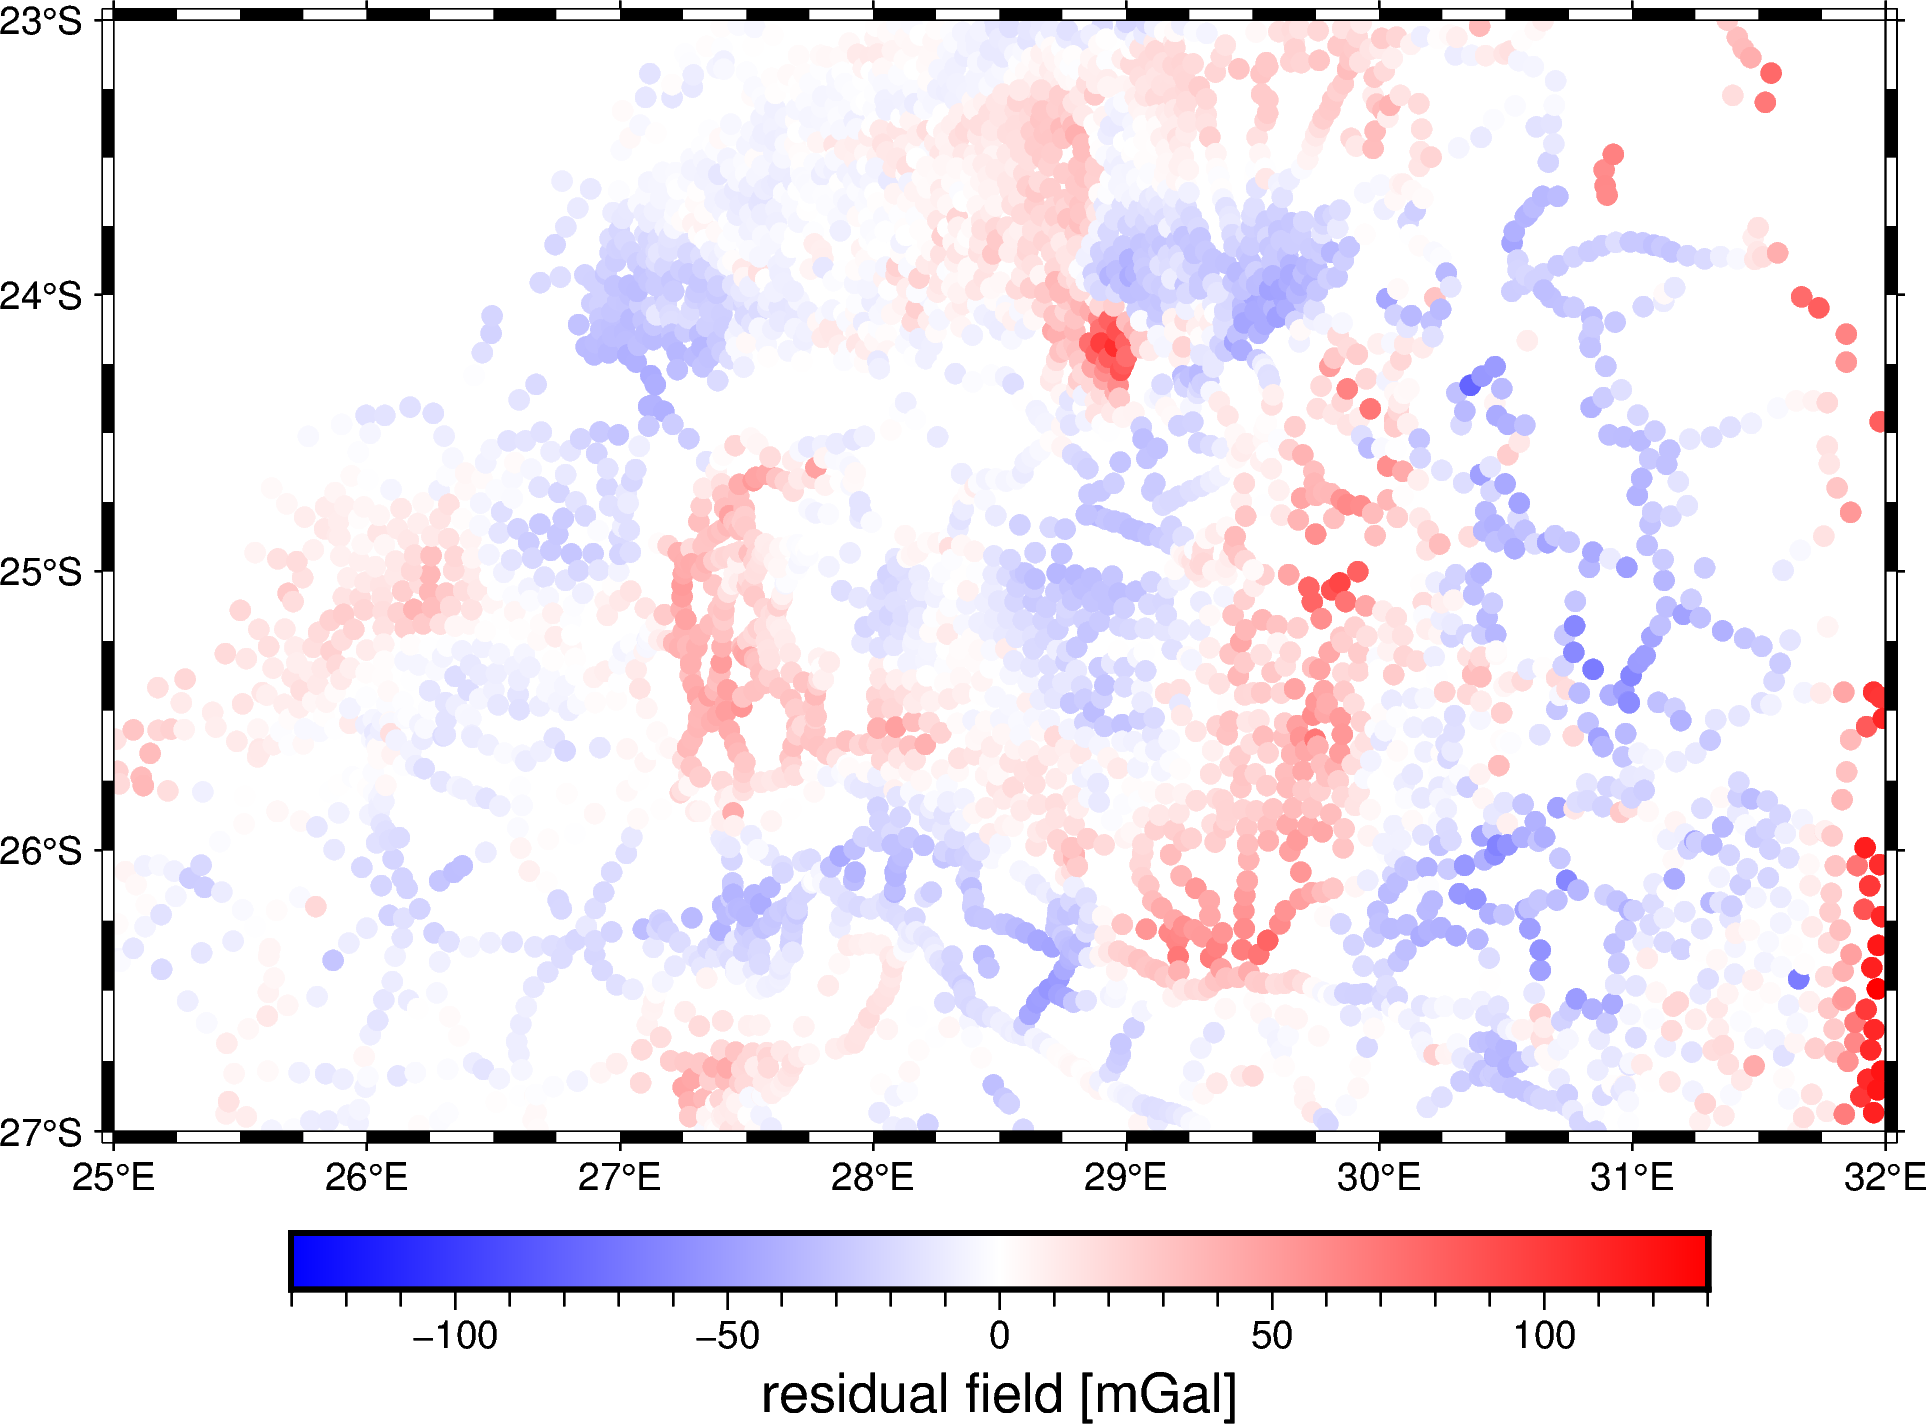

In [24]:
fig = pygmt.Figure()
scale = vd.maxabs(data.gravity_residual_mgal)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_residual_mgal,
    cmap=True,
    style="c5p",
    projection="M15c", 
    frame=True,
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.show()

## Grid the residuals

Finally, we can create a regular grid of the residuals at a uniform height. This is a good way to aid visualization and would also allow us to do calculations involving Fourier transforms and other techniques that required gridded data.

The best way to achieve this is, again, the **equivalent sources** in Harmonica. This method allows us to predict the data values on a grid at whatever height we wish (effectively upward-continuation), all in a single step. Since our goal here is to accurately model and predict the residual field, we'll use a shallower depth so that the sources can reproduce the short wavelengths in our data.

In [29]:
eqs = hm.EquivalentSources(damping=100, depth=10e3)
eqs.fit((data.easting_m, data.northing_m, data.height_geometric_m), data.gravity_residual_mgal)

/home/leo/bin/conda/envs/fatiando-tutorials/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


EquivalentSources(damping=100, depth=10000.0)

Use the source model to forward model the grid at a uniform height. We can use the projection to generate a grid in **geographic coordinates** instead of Cartesian.

In [30]:
residual_grid = eqs.grid(
    upward=2200,
    region=region,
    spacing=2/60,
    data_names=["gravity_residual_mgal"],
    dims=("latitude", "longitude"),
    projection=projection,
)
residual_grid

<xarray.Dataset>
Dimensions:                (latitude: 121, longitude: 211)
Coordinates:
  * longitude              (longitude) float64 25.0 25.03 25.07 ... 31.97 32.0
  * latitude               (latitude) float64 -27.0 -26.97 ... -23.03 -23.0
    upward                 (latitude, longitude) float64 2.2e+03 ... 2.2e+03
Data variables:
    gravity_residual_mgal  (latitude, longitude) float64 0.8694 0.9988 ... 18.44
Attributes:
    metadata:  Generated by EquivalentSources(damping=100, depth=10000.0)

Plot the gridded residuals.

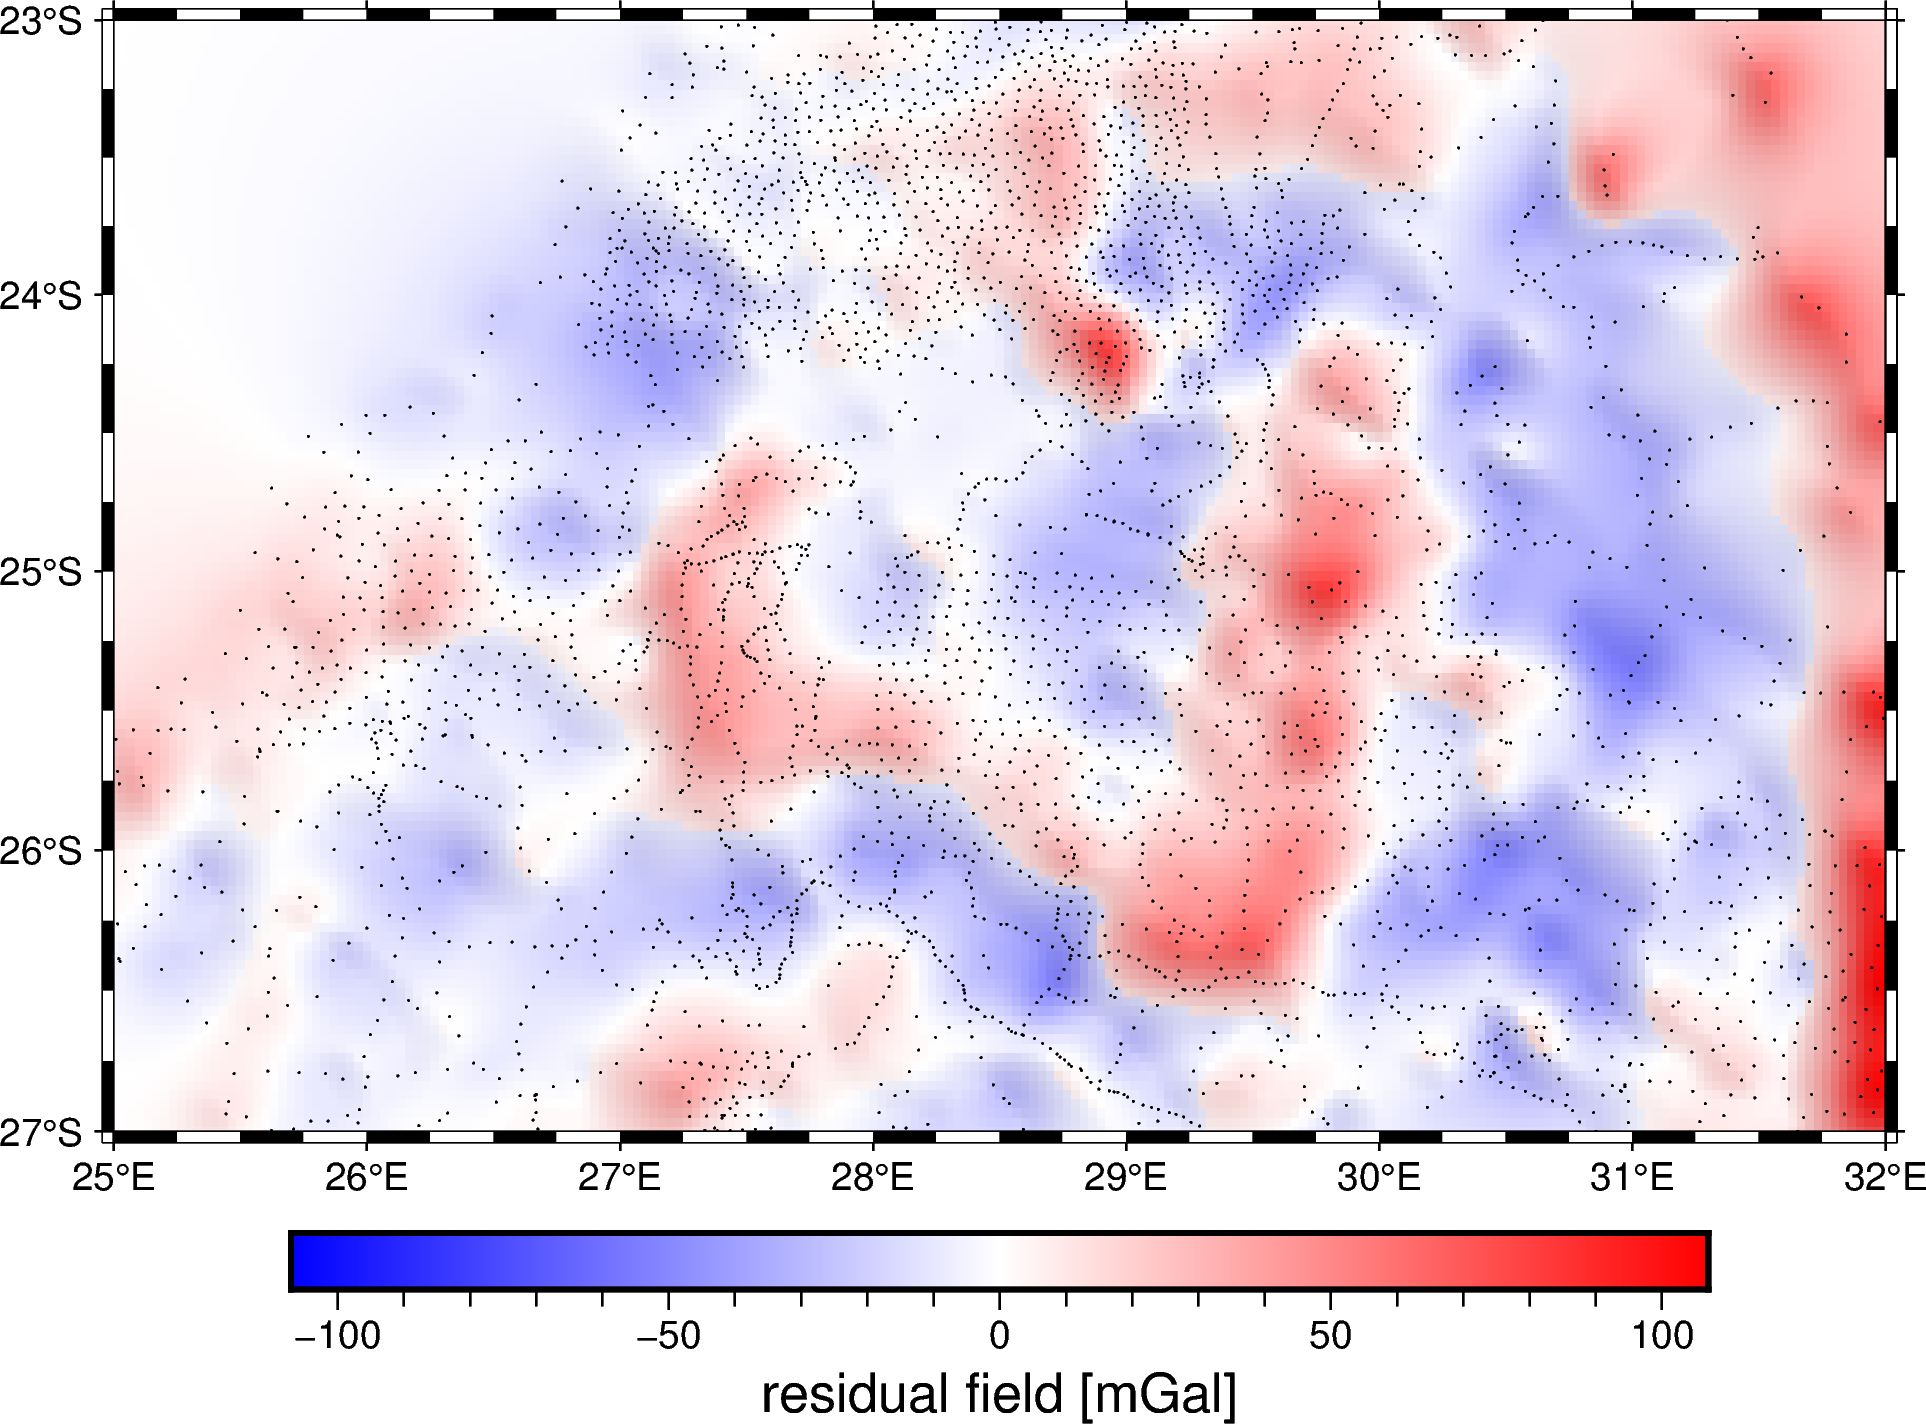

In [35]:
fig = pygmt.Figure()
scale = vd.maxabs(residual_grid.gravity_residual_mgal)
pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
fig.grdimage(
    residual_grid.gravity_residual_mgal,
    shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.longitude,
    y=data.latitude,
    style="c0.02c",
    color="black",
)
fig.show()

## Where to go next

**Congratulations!** You've now completed our gravity processing tutorial. Here are few things you can do now:

* Try using your own data.
* Change the values of certain parameters (topographic density, equivalent source depth, etc) and see what happens.
* Learn more about the individual packages by reading their documentation: https://www.fatiando.org/learn

---

## License

All Python source code is made available under the BSD 3-clause license. You
can freely use and modify the code, without warranty, so long as you provide
attribution to the authors.

Unless otherwise specified, all figures and Jupyter notebooks are available
under the Creative Commons Attribution 4.0 License (CC-BY).

The full text of these licenses is provided in the [`LICENSE.txt`](LICENSE.txt)
file.